In [543]:
from abc import ABC, abstractmethod
from matplotlib import pyplot as plt

import numpy as np
import torch
import torch.nn as nn
from scipy.stats import ortho_group
from torch import exp, tanh, abs, log

# Layer Setup

In [544]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

torch.set_default_device(device)
torch.set_default_dtype(torch.double)

Device: cuda


In [545]:
class FFNN(nn.Module):
    def __init__(self, in_size: int, hidden_sizes: list[int], out_size: int) -> None:
        '''
        Standard feed-forward neural network, used in 'BijectiveLayer'.

        ### Inputs:
        * in_size: Size of input.
        * hidden_sizes: List containing the sizes of the hidden layers.
        * out_size: Size of output.
        '''
        super().__init__()

        # append all layer sizes
        sizes = [in_size] + list(hidden_sizes) + [out_size]

        # initialize linear layers
        layers = [nn.Linear(sizes[i], sizes[i + 1]) for i in range(len(sizes) - 1)]

        # splice in ReLU layers
        for i in range(len(layers) - 1):
            layers.insert(i * 2 + 1, nn.ReLU())

        self.layers = nn.Sequential(*layers)

    def forward(self, X: torch.Tensor):
        return self.layers(X)

In [546]:
class Layer(nn.Module, ABC):
    '''
    Abstract class used as the framework for all types of layers used in the SurVAE-Flow architecture.
    All layers are defined in the inference direction, i.e. the 'forward' method sends elements of the
    data space X to the latent space Z, whereas the 'backward' method goes from Z to X.
    '''
    # TODO: later abc __init__

    @abstractmethod
    def forward(self, X: torch.Tensor, return_likelihood: bool = False): # TODO: rename return_likelihood to return_log_likelihood everywhere
        '''
        Computes the forward pass of the layer and, optionally, the log likelihood contribution as a scalar (i.e. already summed).
        '''
        pass

    @abstractmethod
    def backward(self, Z: torch.Tensor):
        '''
        Computes the backward pass of the layer.
        '''
        pass

In [547]:
class OrthonormalLayer(Layer):
    def __init__(self, size: int):
        '''
        Performs an orthonormal transformation. The transformation is randomly initialized and fixed,
        in particular it cannot be learned.

        ### Inputs:
        * size: Size of input, which is the same for the output.
        '''
        super().__init__()
        
        self.o = torch.tensor(ortho_group.rvs(size))

    def forward(self, X: torch.Tensor, return_likelihood: bool = False):
        if return_likelihood:
            return X @ self.o, 0
        else:
            return X @ self.o

    def backward(self, Z: torch.Tensor):
        return Z @ self.o.T

In [548]:
class BijectiveLayer(Layer):
    def __init__(self, size: int, hidden_sizes: list[int]) -> None:
        '''
        Standard bijective block from normalizing flow architecture.

        ### Inputs:
        * size: Size of input, which is the same for the output.
        * hidden_sizes: Sizes of hidden layers of the nested FFNN.
        '''
        super().__init__()
        
        assert size > 1, "Bijective layer size must be at least 2!"

        # The size of the skip connection is half the input size, rounded down
        self.skip_size = size // 2
        self.non_skip_size = size - self.skip_size

        # The nested FFNN takes the skip connection as input and returns
        # the translation t (of same size as the non-skip connection) and
        # scaling factor s (which is a scalar) for the linear transformation
        self.ffnn = FFNN(self.skip_size, hidden_sizes, self.non_skip_size + 1)

    def forward(self, X: torch.Tensor, return_likelihood: bool = False):
        # split input into skip and non-skip
        skip_connection = X[:, :self.skip_size]
        non_skip_connection = X[:, self.skip_size:]

        # compute coefficients for linear transformation
        coeffs = self.ffnn(skip_connection)
        # split output into t and pre_s
        t = coeffs[:, :-1]
        pre_s = coeffs[:, -1]
        # compute s_log for log-likelihood contribution and fix dimension; shape is (N,) but should be (N, 1)
        s_log = tanh(pre_s).unsqueeze(1)
        # compute s
        s = exp(s_log)

        # apply transformation
        new_connection = s * non_skip_connection + t
        # stack skip connection and transformed non-skip connection
        Z = torch.cat((skip_connection, new_connection), dim=1)

        if return_likelihood:
            return Z, torch.sum(s_log)
        else:
            return Z

    def backward(self, Z: torch.Tensor):
        # split input into skip and non-skip
        skip_connection = Z[:, :self.skip_size]
        non_skip_connections = Z[:, self.skip_size:]

        # compute coefficients for linear transformation
        coeffs = self.ffnn(skip_connection)
        # split output into t and pre_s
        t = coeffs[:, :-1]
        pre_s = coeffs[:, -1]
        # compute s and fix dimension; shape is (N,) but should be (N, 1)
        s = exp(tanh(pre_s)).unsqueeze(1)

        # apply inverse transformation
        new_connection = (non_skip_connections - t) / s
        # stack skip connection and transformed non-skip connection
        X = torch.cat((skip_connection, new_connection), dim=1)

        return X

In [549]:
# testing TODO remove
b = BijectiveLayer(23, [25, 50])
for _ in range(1000):
    a = torch.rand(300, 23)
    assert torch.allclose(a, b.backward(b.forward(a)), atol=1e-5)

b = OrthonormalLayer(23)
for _ in range(1000):
    a = torch.rand(300, 23)
    assert torch.allclose(a, b.backward(b.forward(a)), atol=1e-5)

# Normalizing Flows

In [550]:
class SurVAE(Layer):
    def __init__(self, layer_size: int, layer_description: list[list]):
        '''
        General framework for the SurVAE-Flow architecture. The layers can be specified in 'layer_description'.

        ### Inputs:
        * layer_size: Size of input and output TODO: This only makes sense if all layers go from R^n to R^n. We need a different i.e. better way of defining layers.
        * layer_description: TODO: fix
        '''
        super().__init__()
        
        self.layer_size = layer_size
        
        # TODO'nt
        self.layers = [
            layer_uh_specifications[0](
                layer_size,
                *(layer_uh_specifications[1] if len(layer_uh_specifications) >= 2 else []),
                **(layer_uh_specifications[2] if len(layer_uh_specifications) >= 3 else {})
            )
            for layer_uh_specifications in layer_description
        ]
            
        self.layers = nn.ModuleList(self.layers)

    def forward(self, X: torch.Tensor, return_likelihood: bool = False):
        # TODO: optimize me (don't compute likelihood if it's not needed)
        ll_total = 0
        for layer in self.layers:
            X, ll = layer.forward(X, return_likelihood=True)
            ll_total += ll

        if return_likelihood:
            return X, ll_total
        else:
            return X

    def backward(self, Z: torch.Tensor):
        for layer in reversed(self.layers):
            Z = layer.backward(Z)

        return Z

    def sample(self, n: int) -> torch.Tensor:
        with torch.no_grad():
            # sample from the code distribution, which should be the standard normal
            Z_sample = torch.normal(0, 1, size=(n, self.layer_size), device=device)

            # decode
            return self.backward(Z_sample)

In [551]:
# testing TODO remove
b = SurVAE(
    23,
    [
        [BijectiveLayer, [[5, 5]]],
        [OrthonormalLayer],
    ] * 3,
)

for _ in range(1000):
    a = torch.rand(300, 23)
    assert torch.allclose(a, b.backward(b.forward(a)), atol=1e-5)

# Non-Bijective Layers

In [552]:
class AbsoluteUnit(Layer):
    def __init__(self, size: int, q: torch.Tensor | float, learn_q: bool = False):
        '''
        Performs the absolute value inference surjection.

        ### Inputs:
        * size: Size of input. TODO: once the SurVAE API is better, this shouldn't be needed
        * q: Initial probability to choose each entry's positive representative over the negative.
        * learn_q: Whether q should be learned alongside the rest of the SurVAE flow instead of fixed.
        '''
        super().__init__()
        
        if isinstance(q, float):
            q = torch.tensor(q)
        
        if learn_q:
            q = nn.Parameter(q)

        self.q = q

    def forward(self, X: torch.Tensor, return_likelihood: bool = False):
        if return_likelihood:
            ll_q = torch.ones_like(X) * self.q
            ll_q[X < 0] = 1 - self.q
            
            return abs(X), torch.sum(log(ll_q))
        else:
            return abs(X)

    def backward(self, Z: torch.Tensor):
        s = torch.sign(torch.rand_like(Z) - (1 - self.q))
        return Z * s

In [553]:
def hex_corners(n: int):  # returns n samples
    indexes = np.floor(np.random.rand(n) * 6)  # which corner

    cov = np.array([[0.01, 0], [0, 0.01]])  # cov matrix in 2d for hexagon radius = 1

    X = np.array([(np.cos(index * 2 * np.pi / 6), np.sin(index * 2 * np.pi / 6)) for index in indexes])  # exact corners

    X = X + np.random.multivariate_normal([0.0, 0.0], cov, n)  # corners + deviation

    return torch.tensor(X)

In [554]:
def train_survae_hex(model, batch_size=1000, epochs=1000, lr=0.01, log_count=10):
    optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        x_data = hex_corners(batch_size)
        z, ll = model(x_data, return_likelihood=True)

        loss = (0.5*torch.sum(z**2) - ll) / batch_size
        loss.backward()
        
        optimizer.step()
        
        if (epoch+1) % (epochs // log_count) == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

In [555]:
model = SurVAE(
    2,
    [
        [BijectiveLayer, [[64] * 5]],
        [OrthonormalLayer],
    ] * 10,
)

train_survae_hex(model, batch_size=1000, epochs=100, lr=0.001)

Epoch [10/100], Loss: 0.2127
Epoch [20/100], Loss: -0.2103
Epoch [30/100], Loss: -0.7713
Epoch [40/100], Loss: -0.8498
Epoch [50/100], Loss: -1.0129
Epoch [60/100], Loss: -1.0629
Epoch [70/100], Loss: -1.1029
Epoch [80/100], Loss: -1.1425
Epoch [90/100], Loss: -1.2022
Epoch [100/100], Loss: -1.0155


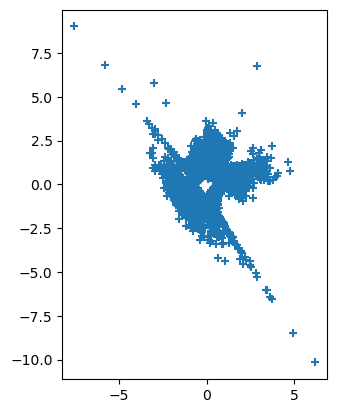

In [556]:
plt.gca().set_aspect('equal')

with torch.no_grad():
    x_data = hex_corners(10000)
    hex_samples = model(x_data).cpu()
    plt.scatter(hex_samples[:, 0], hex_samples[:, 1], marker='+');

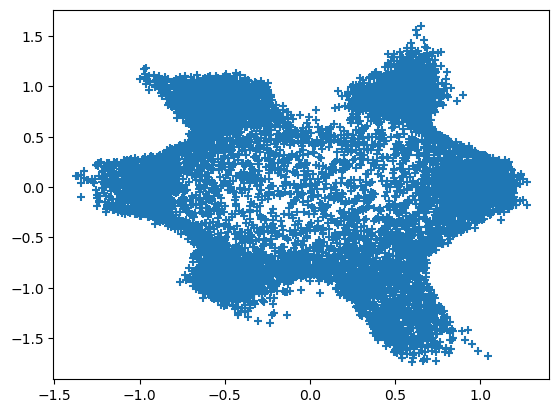

In [557]:
hex_samples = model.sample(10000).cpu()
plt.scatter(hex_samples[:, 0], hex_samples[:, 1], marker='+');

In [558]:
model = SurVAE(
    2,
    [
        [AbsoluteUnit, [1/2]],
    ] + [
        [BijectiveLayer, [[64] * 5]],
        [OrthonormalLayer],
    ] * 10,
)

train_survae_hex(model, batch_size=1000, epochs=100, lr=0.001)

Epoch [10/100], Loss: 0.4775
Epoch [20/100], Loss: -0.7620
Epoch [30/100], Loss: -0.9801
Epoch [40/100], Loss: -1.1255
Epoch [50/100], Loss: -1.2352
Epoch [60/100], Loss: -1.3957
Epoch [70/100], Loss: -1.4711
Epoch [80/100], Loss: -1.4227
Epoch [90/100], Loss: -1.6161
Epoch [100/100], Loss: -1.6334


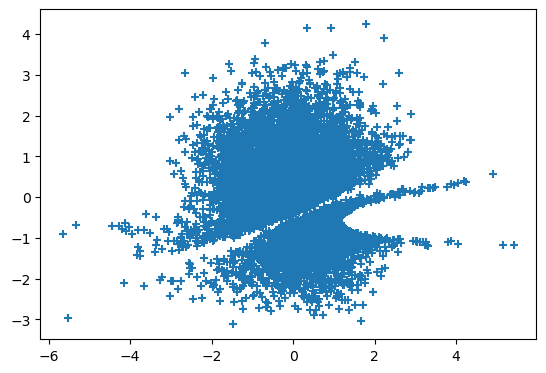

In [559]:
plt.gca().set_aspect('equal')

with torch.no_grad():
    x_data = hex_corners(10000)
    hex_samples = model(x_data).cpu()
    plt.scatter(hex_samples[:, 0], hex_samples[:, 1], marker='+');


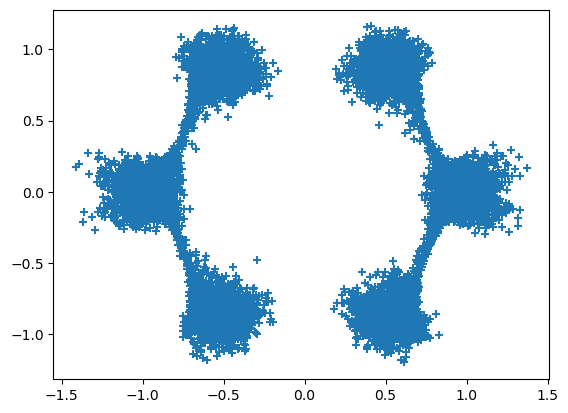

In [560]:
hex_samples = model.sample(10000).cpu()
plt.scatter(hex_samples[:, 0], hex_samples[:, 1], marker='+');


In [561]:
model = SurVAE(
    2,
    [
        [AbsoluteUnit, [1/2], {'learn_q': True}],
    ] + [
        [BijectiveLayer, [[64] * 5]],
        [OrthonormalLayer],
    ] * 10,
)

train_survae_hex(model, batch_size=1000, epochs=500, lr=0.001)


Epoch [50/500], Loss: -1.0917
Epoch [100/500], Loss: -1.4738
Epoch [150/500], Loss: -1.6416
Epoch [200/500], Loss: -1.6970
Epoch [250/500], Loss: -1.6934
Epoch [300/500], Loss: -1.7408
Epoch [350/500], Loss: -1.7151
Epoch [400/500], Loss: -1.7419
Epoch [450/500], Loss: -1.7127
Epoch [500/500], Loss: -1.7800


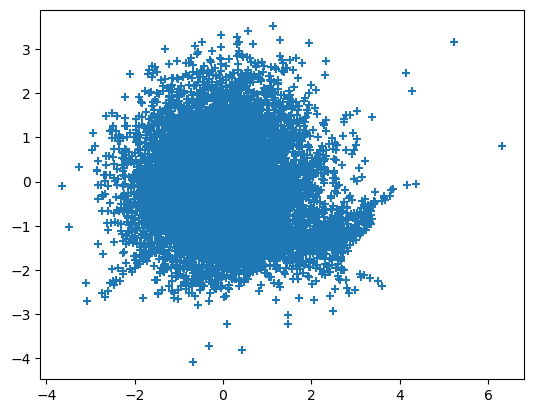

In [562]:
plt.gca().set_aspect('equal')

with torch.no_grad():
    x_data = hex_corners(10000)
    hex_samples = model(x_data).cpu()
    plt.scatter(hex_samples[:, 0], hex_samples[:, 1], marker='+');


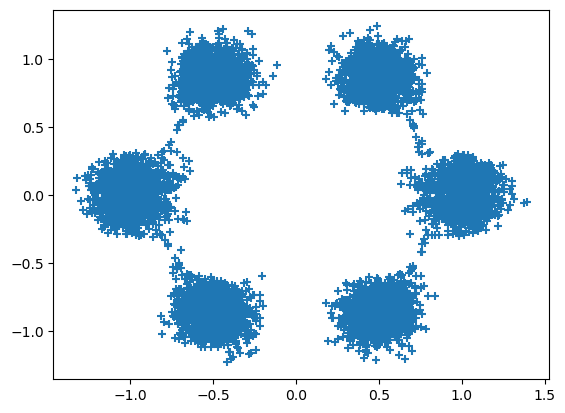

In [563]:
hex_samples = model.sample(10000).cpu()
plt.scatter(hex_samples[:, 0], hex_samples[:, 1], marker='+');


In [564]:
print(model.layers[0].q)

Parameter containing:
tensor(0.4984, device='cuda:0', requires_grad=True)
